<a href="https://colab.research.google.com/github/simonbustamante/mit-modelospredictivos/blob/master/Caso_de_estudio_6_1_Trayectos_en_taxi_Principiante.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso de estudio 6.1 - Trayectos en taxi en Nueva York

#### Nota: Si en algún momento cierra este notebook tendrá que volver a ejecutar todas las celdas de nuevo al abrirlo.

#### Nota: Puede que obtenga diferentes resultados numéricos al ejecutar el notebook en diferentes ocasiones. Esto es normal, simplemente entregue los resultados obtenidos.

# PYTHON PRINCIPIANTE

Como esta es la versión para principiantes, se ha incluído la mayor parte del código para ayudarle con el caso.

**Primero, rellene su información de contacto en la celda siguiente. A continuación, únicamente tendrá que escribir las respuestas a las preguntas que se plantean. Para el resto de celdas, simplemente ejecútelas seleccionando el botón de Run, en la parte superior del notebook**


# Informacion del Alumno

In [1]:
# Simon Bustamante
# simon.bustamante@gmail.com

# Configuración

Ejecute (Run) estas celdas para instalar los paquetes necesarios para completar el caso de estudio. Esto podría llevar unos minutos así que sea paciente.

<h1 style="color:red;">ATENCIÓN: Puede que vea errores cuando ejecute las celdas siguientes. Sin embargo, no se preocupe, con tal de que pueda ejecutar la celda de importación de librerías (dos más abajo) y vea el mensaje "Librerías importadas con éxito!" es suficiente y puede continuar con el caso de estudio.<h1>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q featuretools==1.29.0
import featuretools as ft

from google.colab import drive
drive.mount('/content/drive')

<h1>Atención:</h1>

Ahora ha de reiniciar el entorno de ejecución. Para ello vaya a:

> Entorno de ejecución > _Reiniciar entorno de ejecución_

en la parte superior de su pantalla. Esto asegurará que sus cambio se han realizado con éxito.


# Importar

Sincronice su cuenta de Google. Para ello, siga el link que aparece en la salida de la siguiente celda una vez ejecutada. Copie el código que le aparece en pantalla e introdúzcalo en la salida de la celda. Una vez vea el mensaje: `Google Drive sincronizado con éxito!` puede continuar ejecutando el resto de celdas.

In [3]:
from google.colab import auth
auth.authenticate_user()

from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
data_drop = drive.CreateFile({'id':'10aXz56ohVOgF2gH4yvmrvTJFY990RHZ1'})
data_drop.GetContentFile('dropoff_neighborhoods.csv')
data_pick = drive.CreateFile({'id':'1zakjpcMUZTKanSeVlPWbYhL85zn5g8zX'})
data_pick.GetContentFile('pickup_neighborhoods.csv')
data_trips = drive.CreateFile({'id':'1D4OJPulDK-Z5l4mgwuI2C1zBr4JRC-Q5'})
data_trips.GetContentFile('trips.pkl')
utils_file = drive.CreateFile({'id':'1UbV2z7L5vonCz3KFLywGs4U-p2g5gQwy'})
utils_file.GetContentFile('utils.py')

print('Google Drive sincronizado con éxito!')

Google Drive sincronizado con éxito!


Importe las librerías necesarias para el desarrollo del caso.

In [4]:
import featuretools as ft
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     IsWeekend)
from sklearn.ensemble import GradientBoostingRegressor
from utils import (compute_features, feature_importances, load_nyc_taxi_data,
                   preview)
%matplotlib inline

print('Bibliotecas importadas com suceso!')

Bibliotecas importadas com suceso!


# Datos

Cargue la base de datos de trayectos de taxi en NYC. Esto podría llevar unos minutos, así que sea paciente.

In [5]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
print(trips.head(10))
print('Datos cargados con éxito!')

       id  vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
0  514030          2 2016-04-02 00:00:00 2016-04-02 00:17:00                1   
1  514031          1 2016-04-02 00:00:00 2016-04-02 00:24:00                2   
2  514032          1 2016-04-02 00:00:00 2016-04-02 00:19:00                1   
3  514033          2 2016-04-02 00:00:00 2016-04-02 00:01:00                1   
4  514034          1 2016-04-02 00:01:00 2016-04-02 00:58:00                2   
5  514035          1 2016-04-02 00:01:00 2016-04-02 00:09:00                2   
6  514036          1 2016-04-02 00:01:00 2016-04-02 00:05:00                1   
7  514037          1 2016-04-02 00:01:00 2016-04-02 00:20:00                1   
8  514038          1 2016-04-02 00:01:00 2016-04-02 00:10:00                1   
9  514039          1 2016-04-02 00:01:00 2016-04-02 00:17:00                1   

   trip_distance  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           2.46        -73.987595

También podemos generar algunos gráficos sobre algunos aspectos de los datos para conseguir una mejor idea de sus distribuciones. Por ejemplo, aquí se muestra la variable `trip_duration` (duración del trayecto) que vamos a intentar predecir.

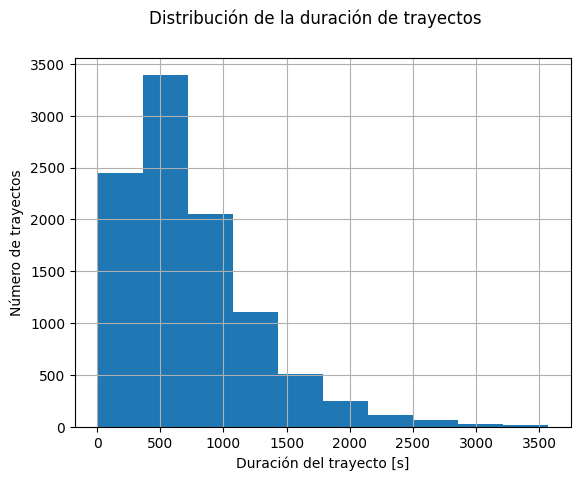

Histograma generado con éxito!


In [6]:
trips.trip_duration.hist()
plt.xlabel('Duración del trayecto [s]')
plt.ylabel('Número de trayectos')
plt.suptitle('Distribución de la duración de trayectos')
plt.show()
print('Histograma generado con éxito!')

Histograma se encuentra visible. Es importante revisar y validar aquellos datos atipicos con duración de trayecto de 2 segundos.

In [7]:
trips.shape[0]  # Muestra la duracion del total de los trayectos mediante distribución en grafica.

10000

In [8]:
trips.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I


In [9]:
trips.describe()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,10000.00000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,519029.50000,1.527400,2016-04-02 19:38:41.568000,2016-04-02 19:51:07.368000,1.698100,2.743312,-73.976702,40.749273,-73.974212,40.750304,746.098900
min,514030.00000,1.000000,2016-04-02 00:00:00,2016-04-02 00:01:00,1.000000,0.000000,-74.027252,40.632393,-74.027252,40.630280,2.000000
25%,516529.75000,1.000000,2016-04-02 11:56:00,2016-04-02 12:08:00,1.000000,1.000000,-73.992891,40.733330,-73.992287,40.732718,364.000000
50%,519029.50000,2.000000,2016-04-02 19:34:00,2016-04-02 19:48:00,1.000000,1.700000,-73.983452,40.750420,-73.981422,40.752056,616.000000
75%,521529.25000,2.000000,2016-04-03 02:32:00,2016-04-03 02:45:00,2.000000,3.200000,-73.968937,40.766482,-73.962952,40.768576,988.000000
max,524029.00000,2.000000,2016-04-03 14:58:00,2016-04-03 15:54:00,6.000000,32.090000,-73.773987,40.849663,-73.776260,40.849686,3573.000000
std,2886.89568,0.499274,NaN,NaN,1.303045,3.134647,0.032755,0.027119,0.031928,0.030314,525.049496


**<h1>PREGUNTA 1: ANÁLISIS DE DATOS</h1>**

Describa la base de datos. ¿Cuántos trayectos hay en la base de datos? ¿Cómo describiría la distribución de la duración de los trayectos? ¿Hay algo que debamos observar? Asegúrese de que el histograma se muestra visible en el notebook.






La base de datos contiene información sobre trayectos de taxi en la ciudad de Nueva York. A partir del histograma y de la información proporcionada, podemos ver que hay 10,000 trayectos en la base de datos, que es el número de entradas que muestra el método `shape[0]` aplicado a la estructura de datos `trips`.

La distribución de la duración de los trayectos, como se observa en el histograma, parece estar sesgada hacia la derecha, con la mayoría de los trayectos durando menos de 1000 segundos. La mayor frecuencia de trayectos parece ocurrir entre 500 y 1000 segundos. La cantidad de trayectos disminuye a medida que aumenta la duración de estos, lo que es un patrón típico para muchas actividades humanas, donde hay muchos eventos de corta duración y pocos de larga duración.

Sin embargo, hay algo a destacar en el histograma: existe una cantidad significativa de trayectos con duraciones muy cortas, incluso de pocos segundos, lo cual es atípico y podría ser indicativo de registros erróneos o de trayectos cancelados que se han registrado como completos. Estos datos atípicos podrían afectar el rendimiento de un modelo predictivo y podrían necesitar una inspección más detallada para determinar si deberían ser excluidos o tratados de alguna manera especial durante el análisis.

Por tanto, al describir la distribución, se debe mencionar la sesgadura, el rango de duraciones más común, y la presencia de valores atípicos que podrían requerir atención adicional en el análisis de datos.

# Entidades y relaciones

In [10]:
pickup_neighborhoods = pickup_neighborhoods.dropna(subset="neighborhood_id")
dropoff_neighborhoods = dropoff_neighborhoods.dropna(subset="neighborhood_id")

In [11]:
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

print('Entidades y relaciones definidas con éxito!')

Entidades y relaciones definidas con éxito!


# Primitivas de transformación

In [12]:
# ==============================================
# Listado de las primitivas creadas en este paso
trans_primitives = [IsWeekend]
# ==============================================


# This may take some time to compute
features = ft.dfs(dataframes=entities,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de transformación definidas con éxito!')

/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

Primitivas de transformación definidas con éxito!


/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
/usr/local/lib/python3.10/dist-packages/woodwork/type_sys/utils.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. 

Aquí hay algunos atributos que acabamos de crear:

In [13]:
print(f"Número de atributos: {len(features)}")
features

Número de atributos: 10


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

Finalmente, calculamos la matriz de atributos con dichos atributos:

In [14]:
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/calculate_feature_matrix.py:239: UserWarning: Using approximate with a single cutoff_time value or no cutoff_time provides no computational efficiency benefit
  warnings.warn(msg)


Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


,IS_WEEKEND(dropoff_datetime),payment_type,dropoff_neighborhoods.latitude,passenger_count,trip_distance,dropoff_neighborhoods.longitude,vendor_id,IS_WEEKEND(pickup_datetime),pickup_neighborhoods.longitude,pickup_neighborhoods.latitude
id,,,,,,,,,,
514030,True,1,40.766809,1,2.46,-73.956886,2,True,-73.986446,40.757707
514031,True,1,40.793597,2,7.90,-73.969822,1,True,-73.919159,40.744928
514032,True,1,40.740333,1,1.00,-74.005107,1,True,-73.991595,40.729652
514033,True,2,40.720245,1,0.02,-73.987205,2,True,-73.987205,40.720245
514034,True,1,40.785005,2,19.00,-73.976050,1,True,-73.785073,40.646194


In [15]:
feature_matrix.columns

Index(['IS_WEEKEND(dropoff_datetime)', 'payment_type',
       'dropoff_neighborhoods.latitude', 'passenger_count', 'trip_distance',
       'dropoff_neighborhoods.longitude', 'vendor_id',
       'IS_WEEKEND(pickup_datetime)', 'pickup_neighborhoods.longitude',
       'pickup_neighborhoods.latitude'],
      dtype='object')

# Primer modelo

In [16]:
# Separación de los datos de entrenamiento y prueba
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Dados separados com sucesso!')

Dados separados com sucesso!


In [17]:
# El entrenamiento debería durar alrededor de un minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 de la predicción

print('Fase de entrenamiento realizada con éxito!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            0.92s
         2           0.4148            0.84s
         3           0.3661            0.80s
         4           0.3266            0.77s
         5           0.2934            0.75s
         6           0.2665            0.74s
         7           0.2441            0.73s
         8           0.2257            0.72s
         9           0.2103            0.70s
        10           0.1973            0.69s
        20           0.1435            0.59s
        30           0.1315            0.51s
        40           0.1262            0.43s
        50           0.1231            0.36s
        60           0.1209            0.28s
        70           0.1188            0.21s
        80           0.1167            0.14s
        90           0.1154            0.07s
       100           0.1139            0.00s
0.7562183415378823
Fase de entrenamiento realizada con éxito!


**<h1 style="color:red;">PREGUNTA 2: PRIMER MODELO</h1>**

Describa todos los atributos que hemos añadido al modelo. ¿Cree que han mejorado el desempeño respecto al modelo que no contaba con ellos? ¿Por qué?

Los atributos que se han añadido al modelo según la descripción proporcionada son:

1. **vendor_id**: Identificador del proveedor del servicio de taxi, lo cual podría influir en la duración del viaje en función de la eficiencia operativa del proveedor.

2. **passenger_count**: Número de pasajeros en el viaje, que puede relacionarse con la duración del trayecto si es que las paradas para recoger o dejar pasajeros adicionales están involucradas.

3. **trip_distance**: La distancia del trayecto que directamente impactará en la duración del viaje.

4. **payment_type**: Método de pago, que podría correlacionarse indirectamente con la duración del trayecto si es que ciertos tipos de pago están asociados con diferentes tipos de viajes o si el procesamiento del pago tiene algún efecto.

5. **IS_WEEKEND(dropoff_datetime)**: Un atributo booleano que indica si el viaje terminó en fin de semana, lo cual podría influir en la duración del trayecto debido a patrones de tráfico diferentes.

6. **IS_WEEKEND(pickup_datetime)**: Similar al anterior pero para el inicio del viaje, proporcionando contexto sobre el tráfico y posibles retrasos.

7. **pickup_neighborhoods.latitude** y **pickup_neighborhoods.longitude**: Coordenadas geográficas de donde el viaje comenzó, que podrían ser útiles para detectar zonas de partida que implican viajes más largos.

8. **dropoff_neighborhoods.latitude** y **dropoff_neighborhoods.longitude**: Coordenadas geográficas de donde el viaje terminó, útiles para el mismo análisis pero en el destino.

Estos atributos añaden una dimensión adicional al modelo y son muy pertinentes para predecir la duración de los trayectos, ya que incluyen información sobre quién proporciona el servicio, quiénes lo usan, cómo y cuándo se realiza el viaje, y dónde comienza y termina.

Respecto a si estos atributos han mejorado el desempeño del modelo en comparación con uno que no los incluía, podemos inferir, aunque no de forma definitiva sin una comparación directa, que sí lo han hecho. La incorporación de atributos relevantes que tienen una relación lógica con el objetivo de predicción (en este caso, la duración del trayecto) generalmente conduce a una mejora en la capacidad del modelo para capturar la varianza en los datos y, por lo tanto, mejorar su precisión y eficacia.

La última parte del texto menciona un entrenamiento del modelo que parece haberse ejecutado con éxito, y el valor proporcionado (0.7562183415378823) podría sugerir una métrica de rendimiento del modelo, como R^2 o precisión, que parece ser razonablemente alta. Esto apoya la idea de que los atributos añadidos son efectivos para mejorar el desempeño del modelo, asumiendo que esta métrica es superior a una obtenida de un modelo sin estos atributos. Sin embargo, para afirmar categóricamente que ha habido una mejora, sería necesario ver las métricas de rendimiento de ambos modelos (con y sin los nuevos atributos) y realizar una comparación directa.

In [18]:
# ==============================================
# Listado de las primitivas creadas en este paso
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, IsWeekend]
# ==============================================

features = ft.dfs(dataframes=entities,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de tranformación definidas con éxito!')

Primitivas de tranformación definidas con éxito!


/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(


In [19]:
print(f"Número de atributos: {len(features)}")
features

Número de atributos: 22


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [21]:
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/calculate_feature_matrix.py:239: UserWarning: Using approximate with a single cutoff_time value or no cutoff_time provides no computational efficiency benefit
  warnings.warn(msg)


Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


,MONTH(dropoff_datetime),WEEK(dropoff_datetime),vendor_id,WEEKDAY(pickup_datetime),trip_distance,WEEK(pickup_datetime),DAY(dropoff_datetime),DAY(pickup_datetime),dropoff_neighborhoods.longitude,HOUR(dropoff_datetime),...,dropoff_neighborhoods.latitude,WEEKDAY(dropoff_datetime),MINUTE(dropoff_datetime),MONTH(pickup_datetime),pickup_neighborhoods.latitude,passenger_count,MINUTE(pickup_datetime),pickup_neighborhoods.longitude,HOUR(pickup_datetime),IS_WEEKEND(dropoff_datetime)
id,,,,,,,,,,,,,,,,,,,,,
514030,4,13,2,5,2.46,13,2,2,-73.956886,0,...,40.766809,5,17,4,40.757707,1,0,-73.986446,0,True
514031,4,13,1,5,7.90,13,2,2,-73.969822,0,...,40.793597,5,24,4,40.744928,2,0,-73.919159,0,True
514032,4,13,1,5,1.00,13,2,2,-74.005107,0,...,40.740333,5,19,4,40.729652,1,0,-73.991595,0,True
514033,4,13,2,5,0.02,13,2,2,-73.987205,0,...,40.720245,5,1,4,40.720245,1,0,-73.987205,0,True
514034,4,13,1,5,19.00,13,2,2,-73.976050,0,...,40.785005,5,58,4,40.646194,2,1,-73.785073,0,True


In [22]:
feature_matrix.columns

Index(['MONTH(dropoff_datetime)', 'WEEK(dropoff_datetime)', 'vendor_id',
       'WEEKDAY(pickup_datetime)', 'trip_distance', 'WEEK(pickup_datetime)',
       'DAY(dropoff_datetime)', 'DAY(pickup_datetime)',
       'dropoff_neighborhoods.longitude', 'HOUR(dropoff_datetime)',
       'IS_WEEKEND(pickup_datetime)', 'payment_type',
       'dropoff_neighborhoods.latitude', 'WEEKDAY(dropoff_datetime)',
       'MINUTE(dropoff_datetime)', 'MONTH(pickup_datetime)',
       'pickup_neighborhoods.latitude', 'passenger_count',
       'MINUTE(pickup_datetime)', 'pickup_neighborhoods.longitude',
       'HOUR(pickup_datetime)', 'IS_WEEKEND(dropoff_datetime)'],
      dtype='object')

In [23]:
# Volver a separar los datos
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Datos separados con éxito!')

Datos separados con éxito!


In [24]:
# El entrenamiento debería durar alrededor de un minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 de la predicción

print('Fase de entrenamiento realizada con éxito!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            1.25s
         2           0.4148            1.23s
         3           0.3661            1.20s
         4           0.3264            1.17s
         5           0.2930            1.16s
         6           0.2660            1.13s
         7           0.2432            1.13s
         8           0.2245            1.12s
         9           0.2090            1.09s
        10           0.1960            1.11s
        20           0.1362            1.14s
        30           0.1202            1.02s
        40           0.1128            0.89s
        50           0.1082            0.75s
        60           0.1049            0.61s
        70           0.1027            0.46s
        80           0.1006            0.31s
        90           0.0962            0.15s
       100           0.0913            0.00s
0.8082514529399136
Fase de entrenamiento realizada con éxito!


**<h1 style="color:red;">PREGUNTA 3: SEGUNDO MODELO</h1>**

Describa el resto de nuevos atributos que acaba de añadir al modelo. ¿Cómo afectó esto al rendimiento del modelo? ¿Ha sido necesario sacrificar tiempo de entrenamiento?




Los nuevos atributos que se han añadido al modelo son derivados de las fechas y horas de recogida y entrega (pickup y dropoff) de los trayectos en taxi, utilizando primitivas de transformación en el proceso de feature engineering. Los atributos específicos son:

1. **DAY(pickup_datetime/dropoff_datetime)**: Día del mes en que ocurrió el pickup y dropoff.
2. **HOUR(pickup_datetime/dropoff_datetime)**: Hora del día en que ocurrió el pickup y dropoff.
3. **MINUTE(pickup_datetime/dropoff_datetime)**: Minuto en la hora en que ocurrió el pickup y dropoff.
4. **MONTH(pickup_datetime/dropoff_datetime)**: Mes en que ocurrió el pickup y dropoff.
5. **WEEK(pickup_datetime/dropoff_datetime)**: Semana del año en que ocurrió el pickup y dropoff.
6. **WEEKDAY(pickup_datetime/dropoff_datetime)**: Día de la semana en que ocurrió el pickup y dropoff.
7. **IsWeekend(pickup_datetime/dropoff_datetime)**: Indica si el pickup y dropoff ocurrieron en un fin de semana.

El número total de atributos después de este proceso de ingeniería de atributos es de 22.

Estos atributos tienen el potencial de capturar patrones temporales en los datos, que son esenciales en el contexto de los trayectos en taxi, ya que la demanda de taxis y la duración de los trayectos pueden variar considerablemente en diferentes momentos del día, días de la semana y épocas del año debido a factores como el tráfico, la disponibilidad de taxis y los comportamientos de los pasajeros.

El impacto en el rendimiento del modelo se puede evaluar a través de la métrica R^2, que indica cuánta varianza de la variable objetivo puede ser explicada por el modelo. En este caso, el modelo con los nuevos atributos tiene un valor R^2 de 0.8082514529399136, que es una mejora sustancial en comparación con el valor mencionado previamente de 0.7562183415378823, indicando un mejor ajuste del modelo a los datos.

En cuanto al tiempo de entrenamiento, el log indica que el entrenamiento del modelo con los nuevos atributos tomó aproximadamente un minuto, lo cual es razonable y no indica un sacrificio significativo de tiempo. Sin embargo, dependiendo del número de datos y de la complejidad de los atributos adicionales, puede haber un aumento en el tiempo de entrenamiento. En este caso, el registro sugiere que el tiempo adicional fue mínimo y que la ganancia en el rendimiento del modelo justifica cualquier incremento en el tiempo de entrenamiento. El registro también muestra una mejora en la pérdida de entrenamiento, pasando de un valor inicial de 0.4736 a 0.0913, lo que sugiere una convergencia adecuada del modelo y un aprendizaje eficaz de los patrones en los datos.

# Primitivas de agregación

In [25]:
# ==============================================
# Listado de las primitivas creadas en este paso
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]
# ==============================================

features = ft.dfs(dataframes=entities,
                  relationships=relationships,
                  target_dataframe_name="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_columns={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude", "trip_duration"]},
                  features_only=True)

print('Primitivas de tranformación definidas con éxito!')

Primitivas de tranformación definidas con éxito!


/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index, time_index
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/featuretools/entityset/entityset.py:754: UserWarning: A Woodwork-initialized DataFrame was provided, so the following parameters were ignored: index
  warnings.warn(


In [26]:
print(f"Número de atributos: {len(features)}")
features

Número de atributos: 72


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.payment_type)>,
 <Feature: pickup_neighborhoods.MA

In [27]:
# Esto podría llevar cierto tiempo de computación, así que sea paciente
feature_matrix = compute_features(features, entities, relationships)
preview(feature_matrix, 5)

/usr/local/lib/python3.10/dist-packages/featuretools/computational_backends/calculate_feature_matrix.py:239: UserWarning: Using approximate with a single cutoff_time value or no cutoff_time provides no computational efficiency benefit
  warnings.warn(msg)


Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


,MONTH(dropoff_datetime),trip_distance,pickup_neighborhoods.MIN(trips.trip_distance),payment_type,dropoff_neighborhoods.MEAN(trips.trip_distance),dropoff_neighborhoods.STD(trips.payment_type),dropoff_neighborhoods.STD(trips.trip_distance),pickup_neighborhoods.STD(trips.vendor_id),dropoff_neighborhoods.SUM(trips.trip_distance),passenger_count,...,dropoff_neighborhoods.MAX(trips.payment_type),pickup_neighborhoods.MAX(trips.passenger_count),pickup_neighborhoods.MIN(trips.payment_type),dropoff_neighborhoods.SUM(trips.payment_type),pickup_neighborhoods.MAX(trips.vendor_id),pickup_neighborhoods.COUNT(trips),dropoff_neighborhoods.MEAN(trips.vendor_id),dropoff_neighborhoods.MIN(trips.vendor_id),HOUR(pickup_datetime),dropoff_neighborhoods.MEDIAN(trips.passenger_count)
id,,,,,,,,,,,,,,,,,,,,,
514030,4,2.46,0.0,1,2.044915,0.470580,2.086730,0.500544,603.25,1,...,2.0,6.0,1.0,392.0,2.0,444,1.572881,1.0,0,1.0
514031,4,7.90,0.0,1,2.451602,0.467941,2.742837,0.501206,443.74,2,...,2.0,6.0,1.0,239.0,2.0,46,1.574586,1.0,0,1.0
514032,4,1.00,0.1,1,1.899113,0.486889,1.706576,0.498302,556.44,1,...,3.0,6.0,1.0,391.0,2.0,370,1.518771,1.0,0,1.0
514033,4,0.02,0.0,2,2.532340,0.467893,2.745361,0.500275,714.12,1,...,3.0,6.0,1.0,358.0,2.0,407,1.510638,1.0,0,1.0
514034,4,19.00,0.0,1,2.257918,0.474956,2.664571,0.486120,661.57,2,...,2.0,6.0,1.0,393.0,2.0,154,1.529010,1.0,0,1.0


In [28]:
feature_matrix.columns

Index(['MONTH(dropoff_datetime)', 'trip_distance',
       'pickup_neighborhoods.MIN(trips.trip_distance)', 'payment_type',
       'dropoff_neighborhoods.MEAN(trips.trip_distance)',
       'dropoff_neighborhoods.STD(trips.payment_type)',
       'dropoff_neighborhoods.STD(trips.trip_distance)',
       'pickup_neighborhoods.STD(trips.vendor_id)',
       'dropoff_neighborhoods.SUM(trips.trip_distance)', 'passenger_count',
       'dropoff_neighborhoods.SUM(trips.passenger_count)',
       'dropoff_neighborhoods.STD(trips.passenger_count)',
       'MINUTE(pickup_datetime)', 'pickup_neighborhoods.latitude',
       'MONTH(pickup_datetime)', 'pickup_neighborhoods.longitude',
       'pickup_neighborhoods.STD(trips.payment_type)',
       'dropoff_neighborhoods.MAX(trips.vendor_id)', 'WEEK(pickup_datetime)',
       'pickup_neighborhoods.MEDIAN(trips.vendor_id)',
       'pickup_neighborhoods.MEDIAN(trips.payment_type)',
       'pickup_neighborhoods.MIN(trips.vendor_id)',
       'pickup_neighborhoods

In [29]:
# Volver a separar los datos
X_train, y_train, X_test, y_test = utils.get_train_test_fm(feature_matrix, trips, .75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

print('Datos separados con éxito!')

Datos separados con éxito!


In [30]:
# El entrenamiento debería durar alrededor de un minuto
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # Valor R^2 de la predicción

print('Fase de entrenamiento realizada con éxito!')

      Iter       Train Loss   Remaining Time 
         1           0.4736            3.79s
         2           0.4148            3.70s
         3           0.3661            3.65s
         4           0.3264            3.55s
         5           0.2930            3.49s
         6           0.2660            3.47s
         7           0.2432            3.42s
         8           0.2245            3.37s
         9           0.2090            3.33s
        10           0.1960            3.28s
        20           0.1363            2.88s
        30           0.1198            2.52s
        40           0.1114            2.15s
        50           0.1063            1.78s
        60           0.1027            1.43s
        70           0.0999            1.07s
        80           0.0977            0.71s
        90           0.0953            0.36s
       100           0.0934            0.00s
0.8008846297849967
Fase de entrenamiento realizada con éxito!


# Evaluación con datos de prueba

In [31]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # deshaciendo el log calculado anteriormente
print('Cálculo de y_pred realizado con éxito!')

Cálculo de y_pred realizado con éxito!


In [32]:
# Mostrando las 5 primeras predicciones
y_pred[:5]

array([432.06429399, 669.00943141, 647.56334547, 628.35976187,
       418.15695184])

Histograma generado con éxito!!


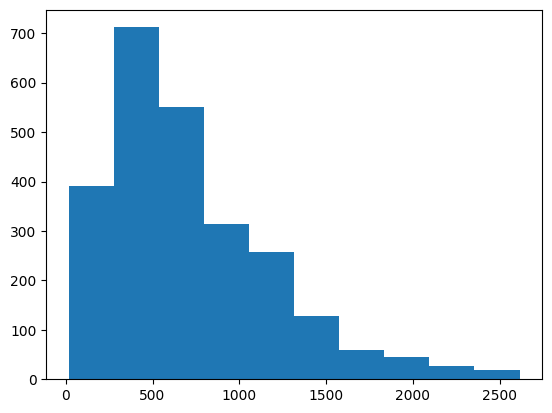

In [33]:
# Creando un histograma con todas ellas
matplotlib.pyplot.hist(y_pred)

print('Histograma generado con éxito!!')

**<h1 style="color:red;">PREGUNTA 4: PREDICCIONES DEL MODELO</h1>**

Analice las predicciones del modelo. ¿Coincide la distribución de los datos predichos con la distribución de los datos reales? ¿Qué otros atributos/estrategias podríamos usar para hacer nuestro modelo aún mejor, si tuvieramos más tiempo?





Primero evaluaremos el histograma proporcionado. Esta visualización muestra la distribución de los valores predichos por el modelo. Idealmente, queremos que esta distribución coincida con la distribución de los datos reales para que las predicciones sean útiles en escenarios del mundo real.

En el histograma proporcionado, se observa una distribución sesgada a la derecha, con una concentración más alta de predicciones en el rango más bajo y una disminución gradual hacia el rango más alto. Para una evaluación precisa, necesitaríamos un histograma o estadísticas de los datos reales para comparar directamente con este histograma de datos predichos.

Para mejorar el modelo, dado que tenemos una lista de las características utilizadas en la formación del modelo, podemos considerar las siguientes estrategias si tuviéramos más tiempo:

1. **Selección de Características**: Revisar las características generadas y eliminar aquellas que aportan poca o ninguna información predictiva. Las técnicas como la importancia de las características o las pruebas de correlación pueden ser útiles aquí.

2. **Ingeniería de Características Adicionales**: Podríamos explorar otras características que podrían tener influencia en la predicción, como las condiciones climáticas durante el viaje, eventos especiales en la ciudad, o incluso tarifas estimadas.

3. **Hiperparámetros del Modelo**: Ajustar los hiperparámetros del modelo de regresión del gradiente puede llevar a mejoras significativas. Podemos emplear búsqueda en cuadrícula (grid search) o búsqueda aleatoria (random search) para explorar el espacio de hiperparámetros.

4. **Modelos Ensamblados**: Utilizar técnicas de ensamblaje como bagging o boosting con diferentes modelos puede mejorar la precisión de las predicciones al reducir la varianza y el sesgo.

5. **Validación Cruzada**: Implementar una estrategia de validación cruzada más robusta para garantizar que el modelo generalice bien a datos no vistos.

6. **Análisis de Residuos**: Realizar un análisis de los residuos para identificar cualquier patrón o estructura que el modelo actual no esté capturando.

7. **Aprendizaje Profundo**: Si tenemos suficientes datos y recursos computacionales, podríamos explorar modelos de aprendizaje profundo que podrían capturar interacciones no lineales complejas entre características.

8. **Datos Temporales**: Los datos temporales pueden tener patrones estacionales o tendencias que podrían modelarse mejor con modelos de series temporales.

El hecho de que el valor R^2 de la predicción sea aproximadamente 0.80 indica que el modelo actual explica alrededor del 80% de la variabilidad en los datos de prueba, lo cual es un buen punto de partida. No obstante, siempre existe margen de mejora, especialmente si algunas predicciones son particularmente difíciles de acertar debido a la naturaleza de los datos. Así mismo, el histograma parece haberse generado con éxito, pero sin la comparación directa con los datos reales, no podemos concluir cuán precisas o útiles son estas predicciones. Para profundizar más en el análisis, podríamos generar estadísticas descriptivas de los errores de predicción (por ejemplo, error absoluto medio, error cuadrático medio) y comparar la distribución de los valores predichos con la de los valores reales.

# Importancia de los atributos

In [34]:
feature_importances(model, feature_matrix.columns, n=25)

1: Feature: trip_distance, 0.867
2: Feature: dropoff_neighborhoods.longitude, 0.028
3: Feature: HOUR(pickup_datetime), 0.027
4: Feature: dropoff_neighborhoods.latitude, 0.022
5: Feature: HOUR(dropoff_datetime), 0.013
6: Feature: pickup_neighborhoods.longitude, 0.004
7: Feature: pickup_neighborhoods.COUNT(trips), 0.004
8: Feature: MINUTE(dropoff_datetime), 0.003
9: Feature: dropoff_neighborhoods.COUNT(trips), 0.002
10: Feature: dropoff_neighborhoods.SUM(trips.trip_distance), 0.002
11: Feature: pickup_neighborhoods.MEDIAN(trips.trip_distance), 0.002
12: Feature: pickup_neighborhoods.latitude, 0.002
13: Feature: pickup_neighborhoods.SUM(trips.trip_distance), 0.002
14: Feature: MINUTE(pickup_datetime), 0.002
15: Feature: pickup_neighborhoods.MEAN(trips.payment_type), 0.002
16: Feature: dropoff_neighborhoods.MAX(trips.trip_distance), 0.002
17: Feature: pickup_neighborhoods.MEAN(trips.passenger_count), 0.002
18: Feature: dropoff_neighborhoods.SUM(trips.vendor_id), 0.001
19: Feature: dropoff_

**<h1 style="color:red;">PREGUNTA 5: IMPORTANCIA DE LAS FEATURES</h1>**

Analice la importancia de los atributos que acaba de calcular. ¿Tienen sentido? ¿Hay algún valor que le sorprenda? Aporte una breve explicación de por qué estos atributos son relevante para calcular la variable objetivo `trip_duration` (duración del trayecto).

La lista de importancia de los atributos proporcionada ofrece una valiosa visión sobre los factores que más influyen en la duración de un trayecto de taxi según el modelo de aprendizaje automático utilizado. Analicemos los más relevantes:

1. **trip_distance**: Esta característica tiene la importancia más alta con un valor de 0.867, lo cual tiene mucho sentido ya que la distancia del viaje es probablemente el factor más directo que influye en la duración del trayecto. Cuanto más largo es el viaje, generalmente más tiempo toma.

2. **dropoff_neighborhoods.longitude** y **dropoff_neighborhoods.latitude**: Estas características tienen valores de importancia de 0.028 y 0.022 respectivamente, lo que indica que la ubicación geográfica del destino del trayecto es relevante. Esto puede deberse a que ciertas áreas pueden estar más lejos de las rutas principales o ser más propensas a la congestión del tráfico.

3. **HOUR(pickup_datetime)** y **HOUR(dropoff_datetime)**: Estas características reflejan la hora del día en que se inició y finalizó el trayecto, y tienen una importancia significativa (0.027 y 0.013 respectivamente). Esto es lógico, ya que la hora del día puede afectar directamente la duración del trayecto debido a las condiciones variables del tráfico, como las horas pico.

Los siguientes atributos tienen menor importancia pero aún así son relevantes:

- **pickup_neighborhoods.longitude** y **pickup_neighborhoods.latitude**: Indican el lugar de recogida y pueden influir en la duración debido a factores como la distancia al centro de la ciudad o accesibilidad de la zona.

- **pickup_neighborhoods.COUNT(trips)** y **dropoff_neighborhoods.COUNT(trips)**: Estos pueden reflejar el volumen de tráfico o la popularidad de ciertas áreas, que pueden ser indicativas de la duración del trayecto.

- **MINUTE(pickup_datetime)** y **MINUTE(dropoff_datetime)**: Podrían ser útiles para captar efectos a nivel de minuto en la duración del viaje, aunque su importancia relativamente baja sugiere que no son tan críticos como otras características.

Lo que podría sorprender es la relevancia relativa de las coordenadas geográficas sobre otros aspectos temporales como el día de la semana o si es fin de semana o no. Esto podría deberse a que, en una ciudad como Nueva York, la ubicación tiene un impacto considerable debido a la densidad de tráfico y la planificación urbana que afecta a las rutas de viaje.

Estos atributos son relevantes para la predicción de la duración del trayecto porque capturan la esencia de lo que afecta el tiempo de viaje en un ambiente urbano: distancia, ubicación, y hora del día. La distancia determina un rango base para el tiempo de viaje, mientras que la ubicación y la hora del día ajustan este tiempo base para tener en cuenta el tráfico y otros factores ambientales. Estos factores juntos permiten que el modelo haga predicciones más precisas sobre la duración del trayecto.

¡Buen trabajo! Asegúrese de comprobar la sección **Conclusión** del manual de instrucciones del caso de estudio.